# Downloads and Views over time
In this notebook, we summarize download statistics we are collecting for the Zenodo records in our database. The code for this was AI-generated.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import requests
import sys

/var/folders/9w/2fk0gqyd2txgyc0ttrl89qt40000gn/T/ipykernel_2941/1323951749.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def read_file_and_date(filename):
    df = pd.read_csv(filename)
    date = pd.to_datetime(filename.replace("\\", "/").split("/")[-1].replace('.csv', ''), format='%Y%m%d')
    return df, date

In [3]:
def get_title_of_zenodo_record(url):
    """Determine the title of a Zenodo record based on its URL."""
    record_id = url.split('/')[-1]
    api_url = f"https://zenodo.org/api/records/{record_id}"
    response = requests.get(api_url)
    record_data = response.json()
    return record_data['metadata']['title']

## Compute Downloads and Views per Day

In [4]:
folder_path = "../download_statistics/"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Sort the files by date
csv_files.sort()

dfs = []

# Process each file
for filename_old, filename_new in zip(csv_files[:-1], csv_files[1:]):
    # load data and determine timestamps
    df_old, date_old = read_file_and_date(folder_path + filename_old)
    df_new, date_new = read_file_and_date(folder_path + filename_new)
    
    # days difference
    days_diff = (date_new - date_old).days

    # Determine the rows in df_new where "url" values are also in df_old
    df_common = df_new[df_new['url'].isin(df_old['url'])]

    # Set the index to "url" for aligning them
    df_old_indexed = df_old.set_index("url")
    df_common_indexed = df_common.set_index("url")

    # Calculate the difference in the "download" column
    download_difference = df_common_indexed["unique_downloads"] - df_old_indexed["unique_downloads"]
    views_difference = df_common_indexed["unique_views"] - df_old_indexed["unique_views"]
    df_common_indexed = df_common_indexed[["authors"]]
    df_common_indexed["downloads_per_day"] = download_difference / days_diff
    df_common_indexed["views_per_day"] = views_difference / days_diff
    df_common_indexed["timestamp"] = date_new

    dfs.append(df_common_indexed)

df = pd.concat(dfs)
df = df.sort_values(by='downloads_per_day', ascending=False)
df = df.reset_index()
df.head()

,url,authors,downloads_per_day,views_per_day,timestamp
0,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03
1,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",13.142857,4.285714,2024-09-17
2,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",11.857143,12.142857,2024-09-24
3,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",10.857143,7.857143,2024-10-01
4,https://zenodo.org/records/11201216,"""Hertweck, Kate and Strasser, Carly and Tarabo...",8.857143,11.142857,2024-09-17


## Plotting downloads per day over time

In [5]:
df = df.sort_values(by='downloads_per_day', ascending=False)


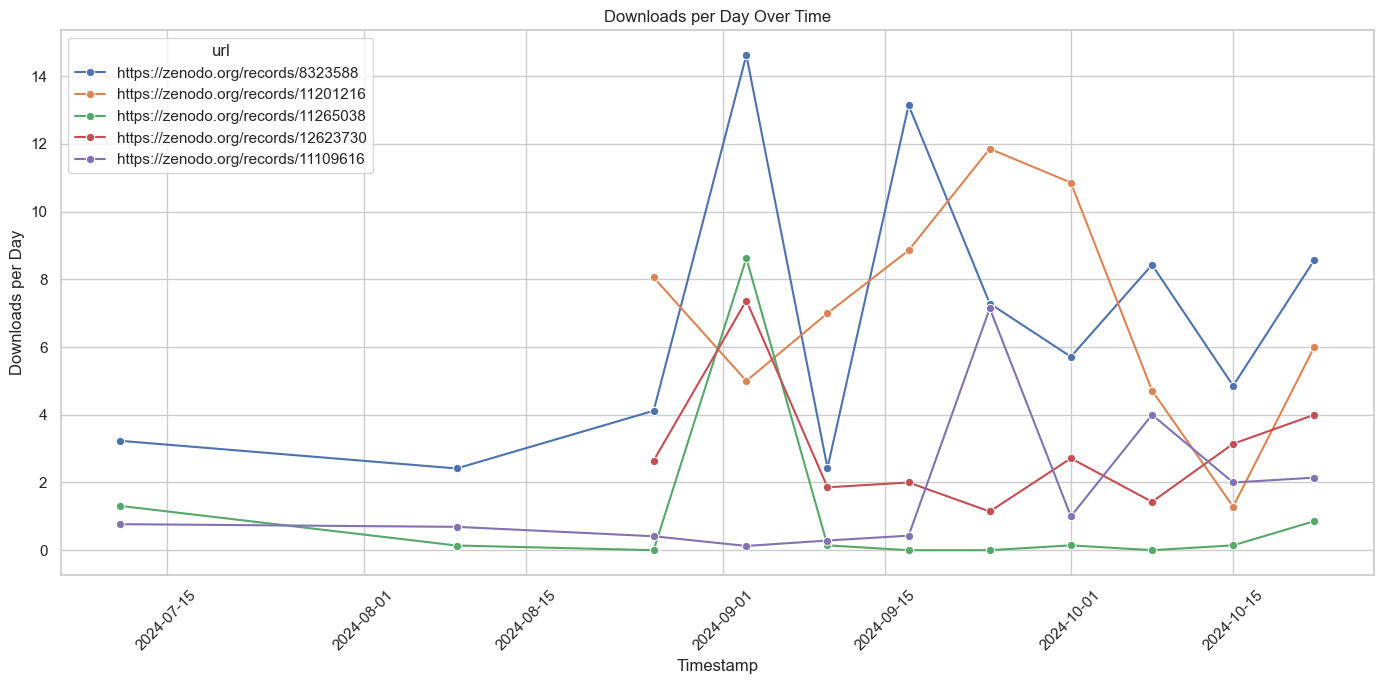

In [6]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Use the first 5 URLs inside the dataframe, if the url is already present, use the next one
top_labels = []
for url in df["url"]:
    if url not in top_labels:
        top_labels.append(url)
    if len(top_labels) == 5:
        break

# Filter the DataFrame to include only the top URLs
filtered_df = df[df['url'].isin(top_labels)]

# Create the line plot
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=filtered_df, x='timestamp', y='downloads_per_day', hue='url', marker='o')

# Add title and labels
plt.title('Downloads per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Downloads per Day')

# Retrieve legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create the legend with the top labels
plt.legend(handles, top_labels, title='url', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()


## Last weeks top 10

/var/folders/9w/2fk0gqyd2txgyc0ttrl89qt40000gn/T/ipykernel_2941/1466662286.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)


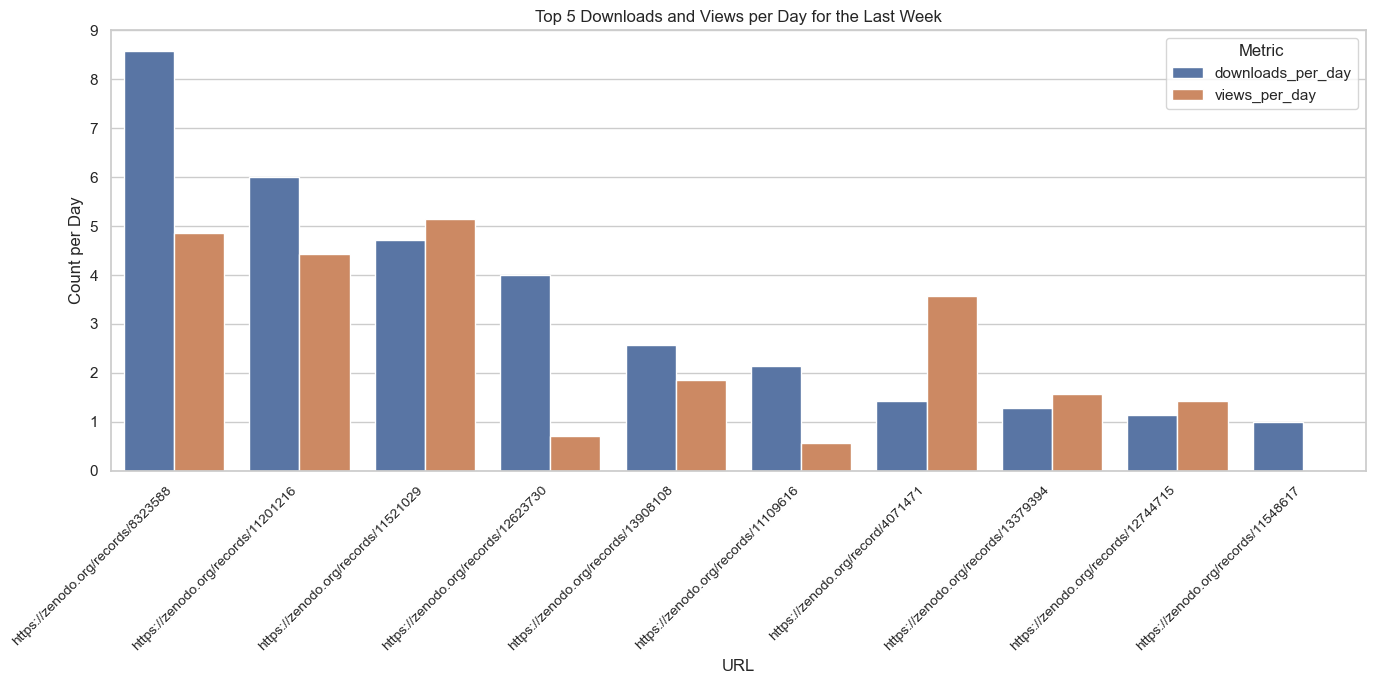

In [7]:
last_week = df[df["timestamp"] == df["timestamp"].max()]

# create a vertical bar plot for df last_week were we always show downloads_per_day and views_per_day next to each other for the same url
# Set the style for seaborn plots
sns.set(style="whitegrid")


# Filter the DataFrame to include only the top 5 entries
top_5 = last_week.nlargest(10, 'downloads_per_day')

# Create a new DataFrame for plotting
plot_data = pd.melt(top_5, id_vars=['url'], value_vars=['downloads_per_day', 'views_per_day'], var_name='Metric', value_name='Count')

# Create the bar plot
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=plot_data, x='url', y='Count', hue='Metric')

# Add title and labels
plt.title('Top 5 Downloads and Views per Day for the Last Week')
plt.xlabel('URL')
plt.ylabel('Count per Day')

# Rotate x-axis labels for better readability and customize the labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)

plt.tight_layout()
plt.legend(title='Metric')
plt.show()


## Plotting views per day over time

In [8]:
# Filter the DataFrame to include only the top URLs
df_views = df.sort_values(by='views_per_day', ascending=False)

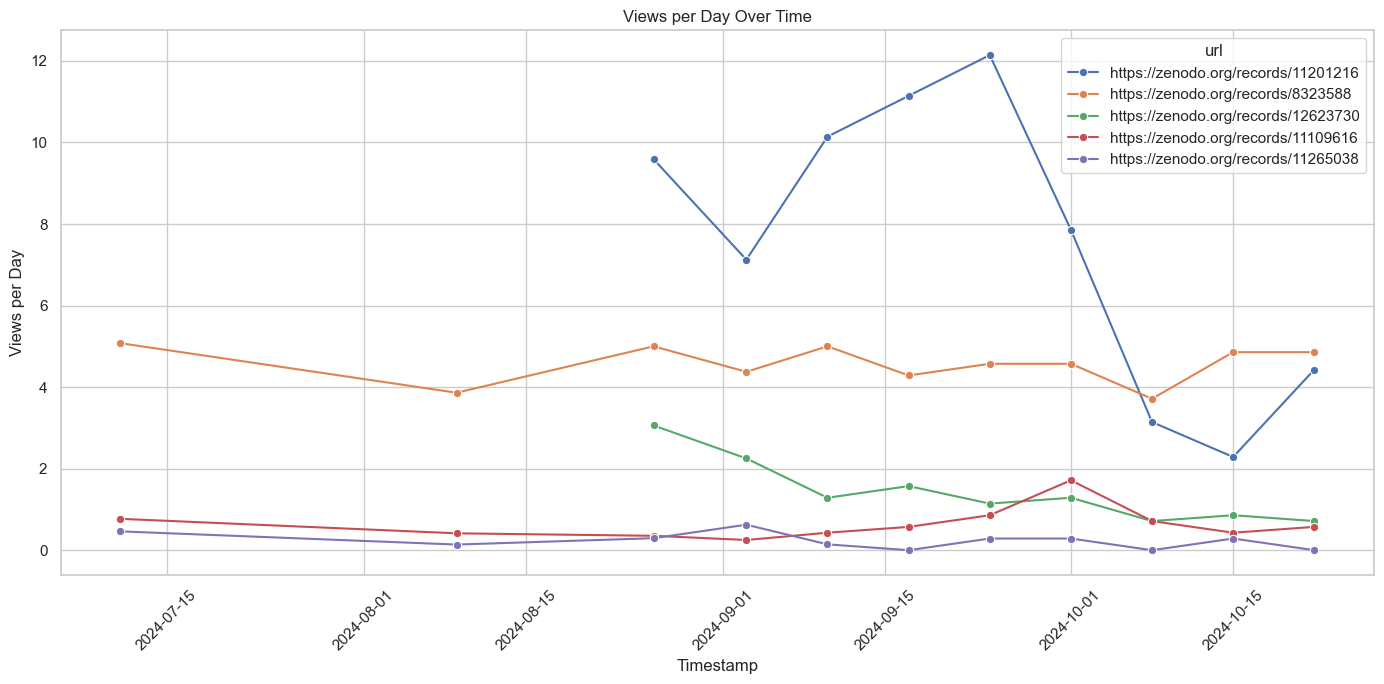

In [9]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Use the first 5 URLs inside the dataframe, if the url is already present, use the next one
top_labels_views = []
for url in df["url"]:
    if url not in top_labels_views:
        top_labels_views.append(url)
    if len(top_labels_views) == 5:
        break

# Filter the DataFrame to include only the top URLs
filtered_df_views = df_views[df_views['url'].isin(top_labels_views)]

# Create the line plot
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=filtered_df_views, x='timestamp', y='views_per_day', hue='url', marker='o')

# Add title and labels
plt.title('Views per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Views per Day')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

## Combining Downloads and Views per Day

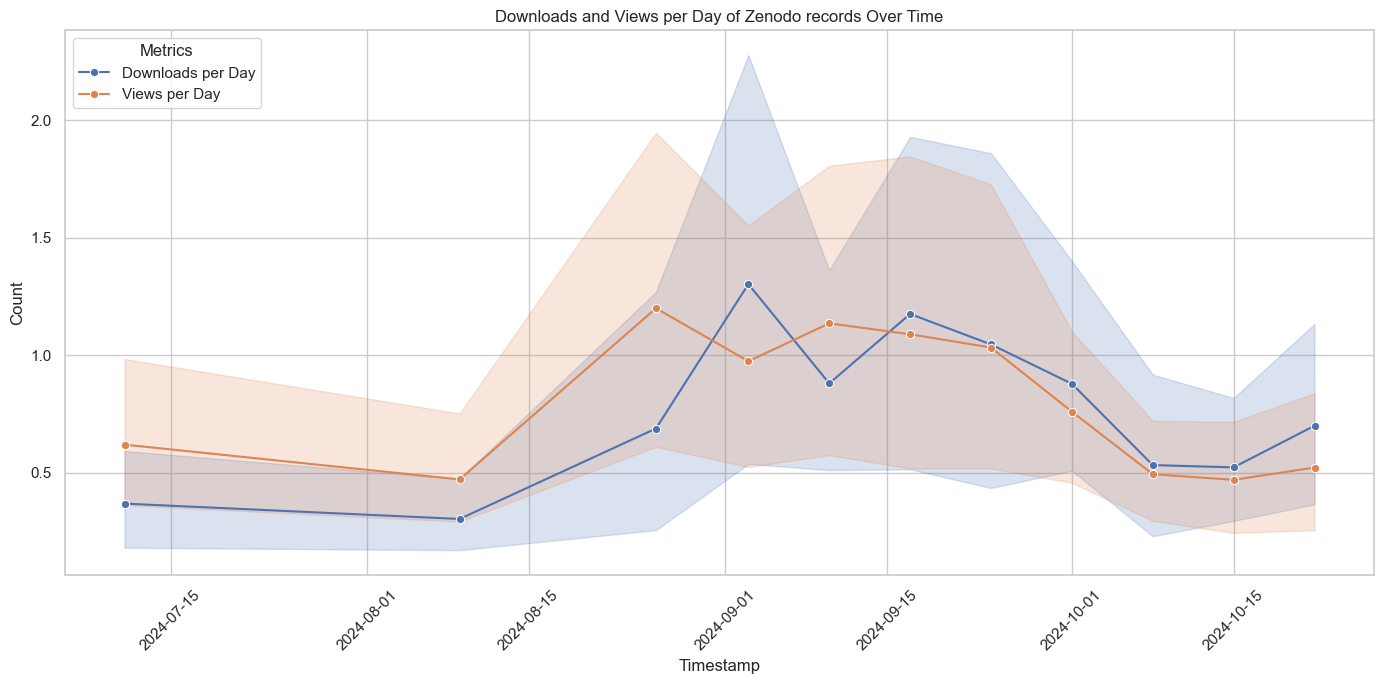

In [10]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='downloads_per_day', data=df, label='Downloads per Day', marker='o')
sns.lineplot(x='timestamp', y='views_per_day', data=df, label='Views per Day', marker='o')

# Add title and labels
plt.title('Downloads and Views per Day of Zenodo records Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Add a legend to differentiate the lines
plt.legend(title='Metrics', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
#plt.savefig("../docs/statistics/downloads_and_views_over_time.png", dpi=700)
plt.show()

## Downloads of our ressources vs other ressources

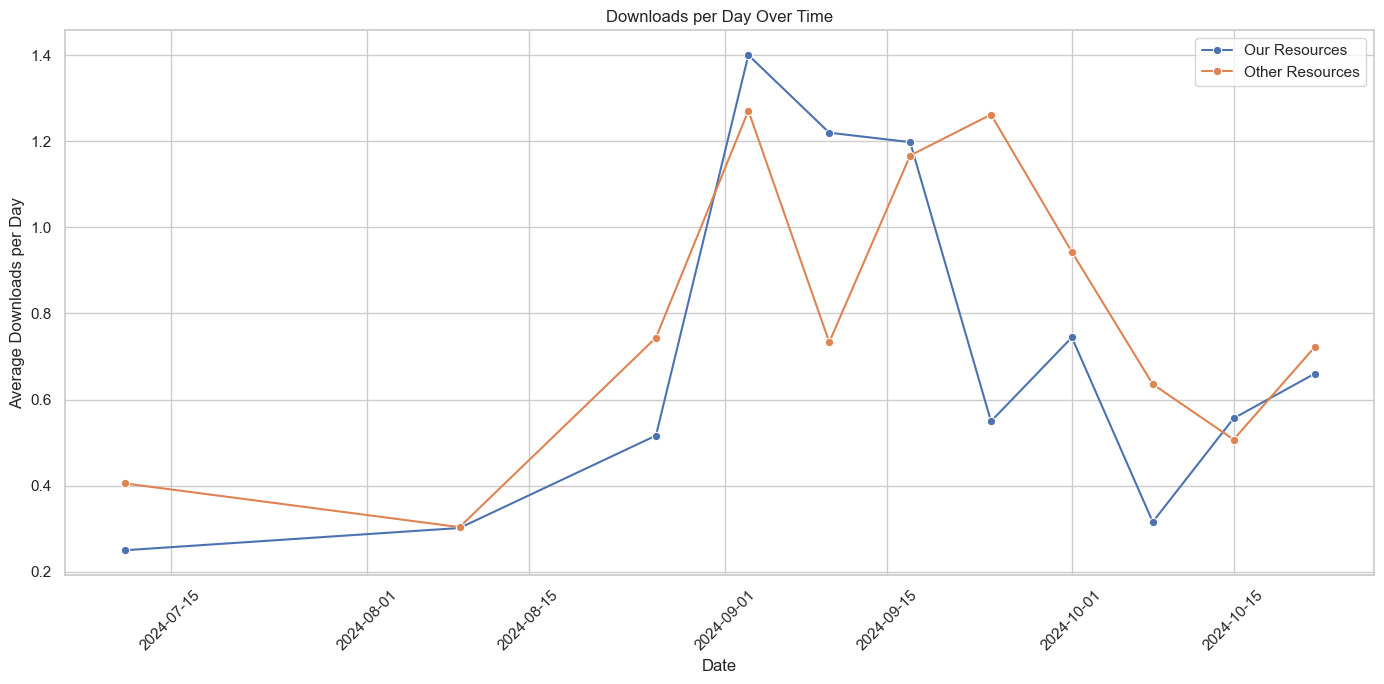

In [11]:
sys.path.append("..")  # Add the project root directory to the Python path
from authors import our_authors

# Create a boolean column indicating if a resource is "ours"
df['is_ours'] = df['authors'].apply(lambda x: any(author in x for author in our_authors))

# Convert timestamp to datetime if it isn't already
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Group by date and is_ours to get the average downloads per day for each category over time
daily_downloads = (
    df.groupby([df['timestamp'].dt.date, 'is_ours'])['downloads_per_day']
    .mean()
    .unstack(fill_value=0)
)

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x=daily_downloads.index, y=daily_downloads[True], label='Our Resources', marker='o')
sns.lineplot(x=daily_downloads.index, y=daily_downloads[False], label='Other Resources', marker='o')

# Add title and labels
plt.xlabel('Date')
plt.ylabel('Average Downloads per Day')
plt.title('Downloads per Day Over Time')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit

# Show the plot
plt.show()

## Percentage of entries by tag category

In [12]:
# Load the YAML file
with open("../resources/nfdi4bioimage.yml", "r") as f:
    yml_data = yaml.safe_load(f)

# Function to get tags from the YAML file
def get_tag(url):
    for entry in yml_data.get("resources", []):
        if 'url' in entry:
            entry_urls = entry['url']
            if isinstance(entry_urls, list):
                if url in entry_urls:
                    tags = entry.get("tags", [])
                    return ', '.join(tags) if tags else "No Tag"
            elif entry_urls == url:
                tags = entry.get("tags", [])
                return ', '.join(tags) if tags else "No Tag"
    return "No Tag"

# Apply the function to extract tags
df['tags'] = df['url'].apply(get_tag)

# Split tags into separate entries and filter out "No Tag"
tag_series = df['tags'].str.split(', ').explode()  
tag_series = tag_series[tag_series != "No Tag"] 

# Calculate the percentage of entries with each tag
entry_percentage = tag_series.value_counts(normalize=True)  # Normalize for percentages
entry_percentage

tags
Research Data Management     0.361783
Fair-Principles              0.098089
Bioimage Analysis            0.067516
Licensing                    0.056051
Nfdi4Bioimage                0.056051
Teaching                     0.028025
Data Protection              0.028025
Bio-Image Analysis           0.028025
Python                       0.025478
Deep Learning                0.025478
Git                          0.014013
Large Language Models        0.014013
Open Access                  0.014013
Tu Dresden                   0.014013
Bioimage Data                0.014013
Zenodo                       0.014013
Workflow Engine              0.014013
Omero                        0.014013
Data Stewardship             0.014013
Open Science                 0.014013
Image Segmentation           0.014013
I3Dbio                       0.014013
Microscopy Image Analysis    0.011465
Sustainability               0.011465
Funding                      0.011465
Open Source Software         0.011465
Reprodu

In [13]:
colorpalette = [
    "#377eb8", "#e41a1c", "#4daf4a", "#984ea3", "#ff7f00",
    "#ffff33", "#a65628", "#f781bf", "#999999", "#66c2a5",
    "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f",
    "#e5c494", "#b3b3b3", "#a6cee3", "#1f78b4", "#b2df8a",
    "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00",
    "#d55e00", "#cc79a7"
]

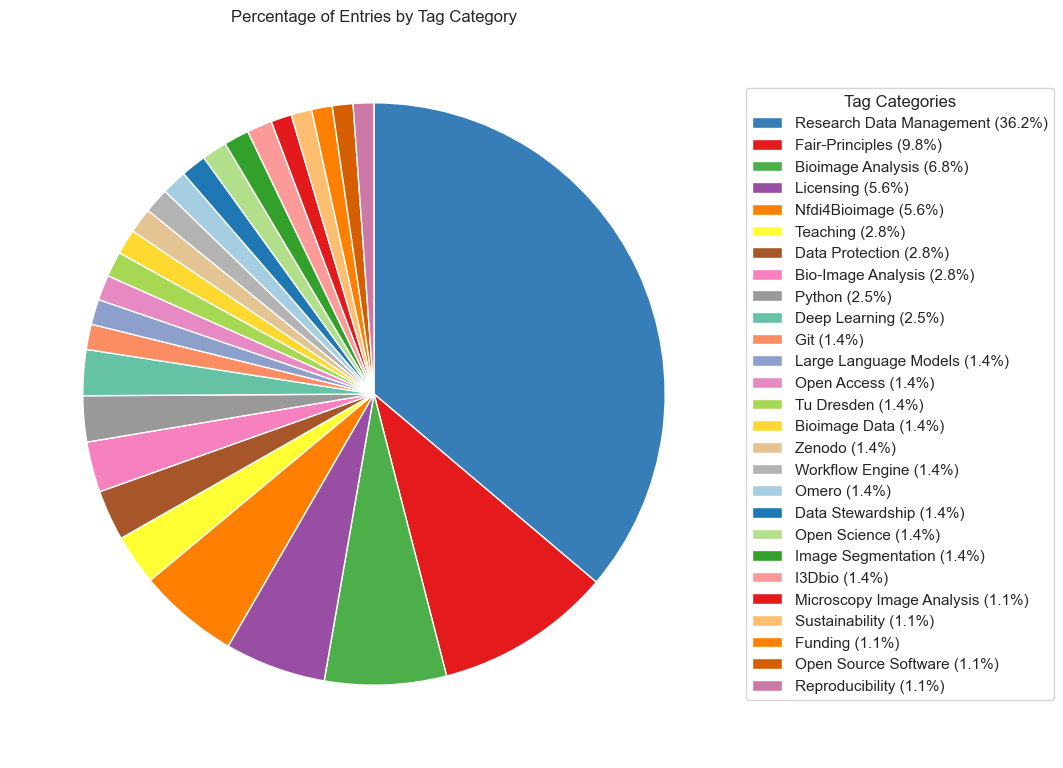

In [14]:
# Plotting the pie chart
fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts = ax.pie(
    entry_percentage,
    labels=None,  # Suppress slice labels
    startangle=90,  # Rotate the chart because it is more intuitive to start from top
    counterclock=False, 
    colors=colorpalette[:len(entry_percentage)]
)

# Format legend labels to include percentages
legend_labels = [f'{label} ({percentage:.1%})' for label, percentage in zip(entry_percentage.index, entry_percentage)]

ax.legend(
    wedges,
    legend_labels,
    title="Tag Categories",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.title("Percentage of Entries by Tag Category")
plt.tight_layout()
plt.show()


Note that in this plot only the entries that have tags are considered. This explains why the entries only sum up to 96.9 %, the other 3.1% have no tag. 

## Relative Dowload Frequency by Tag Category

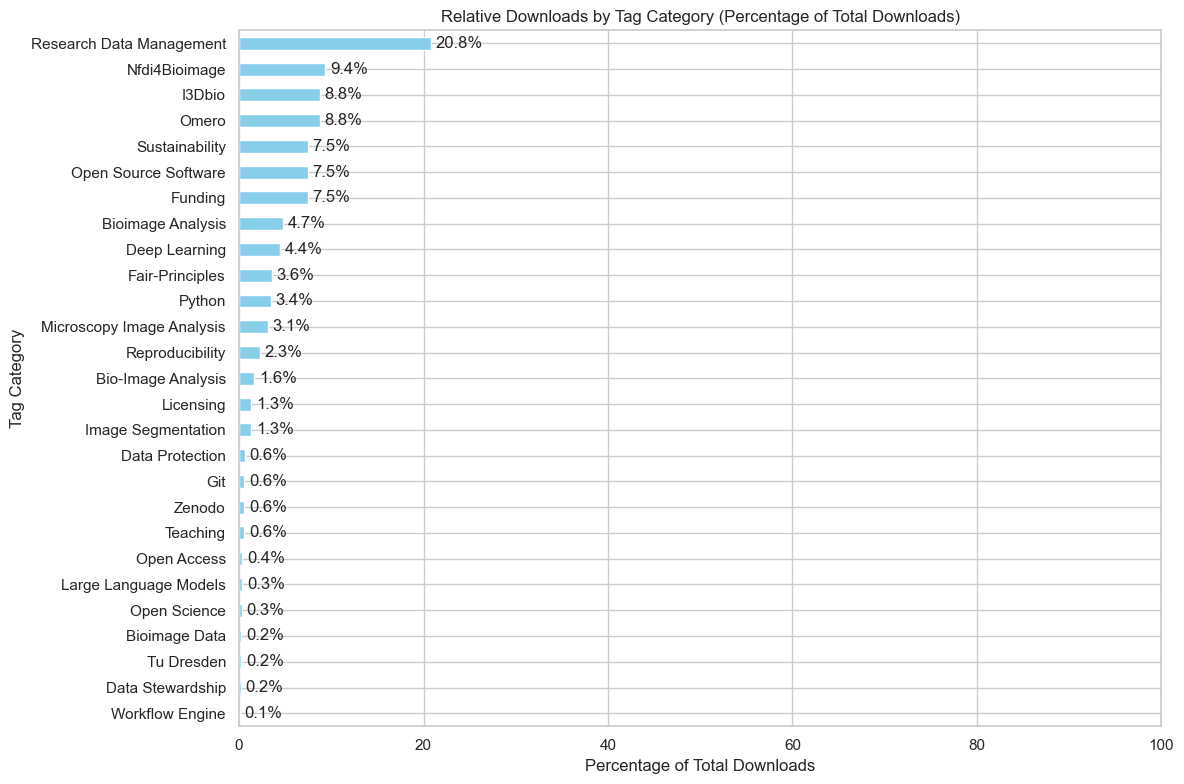

In [15]:
# Ensure 'downloads_per_day' is numeric
df['downloads_per_day'] = pd.to_numeric(df['downloads_per_day'], errors='coerce')

# Filter out rows where tags are "No Tag"
df = df[df['tags'] != "No Tag"]

# Split tags into separate entries and explode them
df['tags_split'] = df['tags'].str.split(', ')
df_exploded = df.explode('tags_split')
df_exploded.rename(columns={'tags_split': 'individual_tag'}, inplace=True)

# Sum downloads by individual tag
downloads_by_tag = df_exploded.groupby('individual_tag')['downloads_per_day'].sum()

# Calculate relative downloads as percentages
total_downloads = downloads_by_tag.sum()
relative_downloads = (downloads_by_tag / total_downloads) * 100

# Sort values for plotting
relative_downloads = relative_downloads.sort_values()

# Plotting the horizontal bar chart
plt.figure(figsize=(12, 8))
ax = relative_downloads.plot(kind='barh', color='skyblue')

plt.title("Relative Downloads by Tag Category (Percentage of Total Downloads)")
plt.xlabel("Percentage of Total Downloads")
plt.ylabel("Tag Category")
plt.xlim(0, 100)  # Set x-axis from 0 to 100%

# Add percentage labels to the bars
for bar in ax.patches:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, 
            f"{bar.get_width():.1f}%", va='center')

plt.tight_layout()
plt.show()

## Viewing downloads and views for specific documents

In [16]:
df_doc = df[df["url"] == "https://zenodo.org/records/8323588"]
df_doc

,url,authors,downloads_per_day,views_per_day,timestamp,is_ours,tags,tags_split
0,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",14.625000,4.375000,2024-09-03,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
1,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",13.142857,4.285714,2024-09-17,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
6,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",8.571429,4.857143,2024-10-22,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
7,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",8.428571,3.714286,2024-10-08,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
10,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",7.285714,4.571429,2024-09-24,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
15,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",5.714286,4.571429,2024-10-01,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
18,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",4.857143,4.857143,2024-10-15,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
24,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",4.117647,5.000000,2024-08-26,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
33,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",3.230769,5.076923,2024-07-11,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."
44,https://zenodo.org/records/8323588,"""Schmidt, Christian and Bortolomeazzi, Michele...",2.428571,5.000000,2024-09-10,False,"Omero, Research Data Management, Nfdi4Bioimage...","[Omero, Research Data Management, Nfdi4Bioimag..."


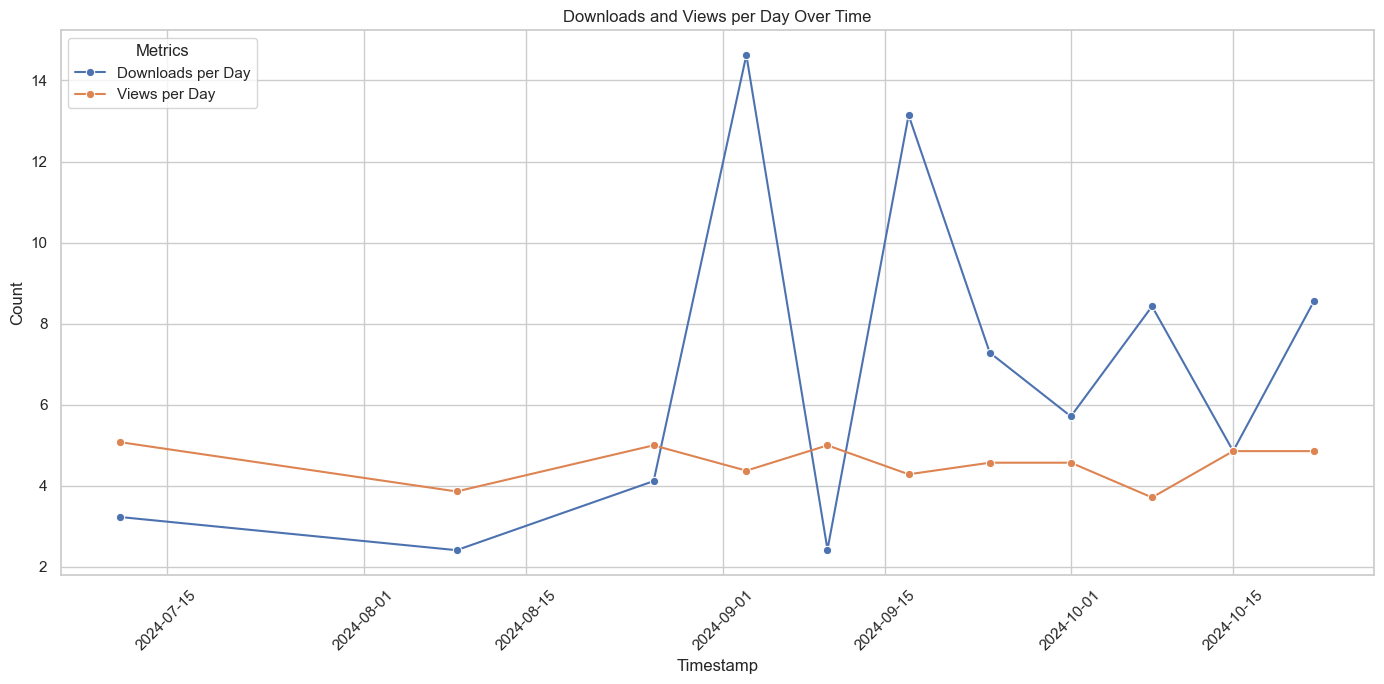

In [17]:
# Set the style for seaborn plots
sns.set(style="whitegrid")

# Create a line plot for both 'downloads_per_day' and 'views_per_day'
plt.figure(figsize=(14, 7))
sns.lineplot(x='timestamp', y='downloads_per_day', data=df_doc, label='Downloads per Day', marker='o')
sns.lineplot(x='timestamp', y='views_per_day', data=df_doc, label='Views per Day', marker='o')

# Add title and labels
plt.title('Downloads and Views per Day Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Count')

# Add a legend to differentiate the lines
plt.legend(title='Metrics', loc='upper left')

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout for better fit
plt.show()

## Number of Records in the Database

In [18]:
# Assuming `df` has a 'timestamp' column
#df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure timestamp is in datetime format
record_counts = df.groupby(df['timestamp'].dt.to_period('D')).size().reset_index(name='counts')
record_counts["timestamp"] = [str(d) for d in record_counts["timestamp"]]
record_counts

,timestamp,counts
0,2024-07-11,32
1,2024-08-09,32
2,2024-08-26,35
3,2024-09-03,35
4,2024-09-10,35
5,2024-09-17,35
6,2024-09-24,35
7,2024-10-01,35
8,2024-10-08,35
9,2024-10-15,35


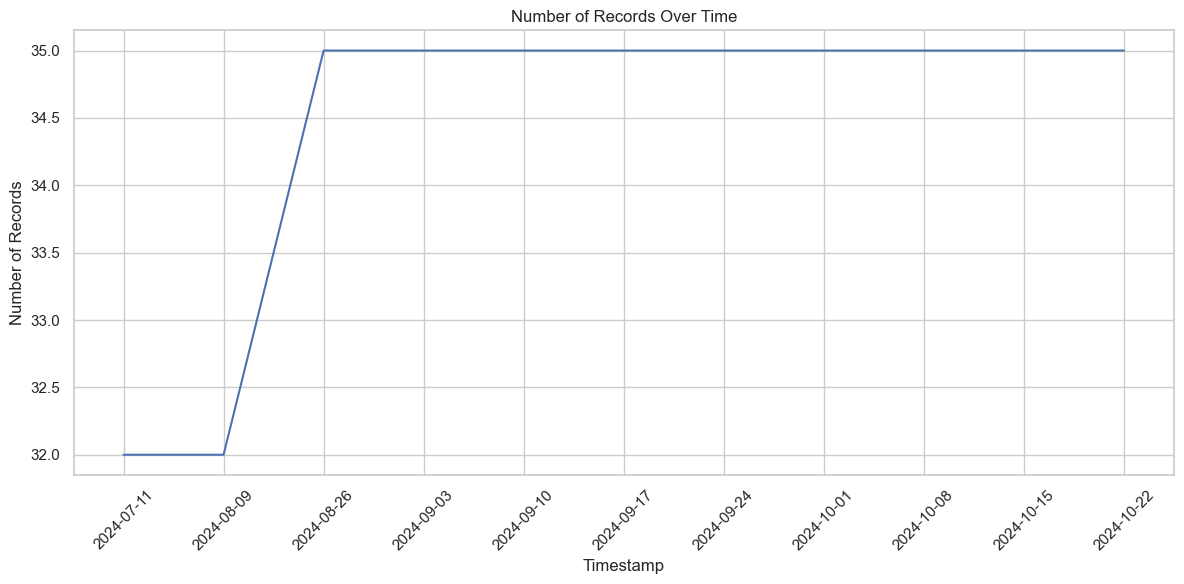

In [19]:
# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='timestamp', y='counts', data=record_counts)
plt.title('Number of Records Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()